# notMNIST, tensorflow, 2-layer FC neural net vs. TT net

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import tensorflow as tf
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from itertools import izip, product

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

## This tutorial includes the following parts

- Getting to know the notMNIST dataset
- Intro to tensorflow
- Classify notMNIST data set using a 2-layer FC neural network
- Classify notMNIST data set using a lazy 2-layer TT network
- Compare the two methods

## Gatting to know the notMNIST dataset

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

<img src="files/notMNIST_fig.png">

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


In [4]:
train_folders

['notMNIST_large/A',
 'notMNIST_large/B',
 'notMNIST_large/C',
 'notMNIST_large/D',
 'notMNIST_large/E',
 'notMNIST_large/F',
 'notMNIST_large/G',
 'notMNIST_large/H',
 'notMNIST_large/I',
 'notMNIST_large/J']

In [5]:
test_folders

['notMNIST_small/A',
 'notMNIST_small/B',
 'notMNIST_small/C',
 'notMNIST_small/D',
 'notMNIST_small/E',
 'notMNIST_small/F',
 'notMNIST_small/G',
 'notMNIST_small/H',
 'notMNIST_small/I',
 'notMNIST_small/J']

You can use display() to view the image files

In [6]:
display(Image(filename="notMNIST_small/A/Q2F0dWxsIChSKSBNZWRpdSBPc0YudHRm.png"))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [7]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large/A.pickle already present - Skipping pickling.
notMNIST_large/B.pickle already present - Skipping pickling.
notMNIST_large/C.pickle already present - Skipping pickling.
notMNIST_large/D.pickle already present - Skipping pickling.
notMNIST_large/E.pickle already present - Skipping pickling.
notMNIST_large/F.pickle already present - Skipping pickling.
notMNIST_large/G.pickle already present - Skipping pickling.
notMNIST_large/H.pickle already present - Skipping pickling.
notMNIST_large/I.pickle already present - Skipping pickling.
notMNIST_large/J.pickle already present - Skipping pickling.
notMNIST_small/A.pickle already present - Skipping pickling.
notMNIST_small/B.pickle already present - Skipping pickling.
notMNIST_small/C.pickle already present - Skipping pickling.
notMNIST_small/D.pickle already present - Skipping pickling.
notMNIST_small/E.pickle already present - Skipping pickling.
notMNIST_small/F.pickle already present - Skipping pickling.
notMNIST_small/G.pickle 

After centering the datasets, numpy array can be directly ploted using pyplot's imshow() function

In [8]:
def display_random_pickled_image(letter):
    dataset_name = 'notMNIST_small/'+letter+'.pickle'
    if os.path.exists(dataset_name):
        with open(dataset_name, 'rb') as handle:
            dataset = pickle.load(handle)
        imag_index = np.random.randint(len(dataset))
        plt.imshow(dataset[imag_index])
    else:
        print('Specified letter '+letter+' does not have an associated data set!')
    return

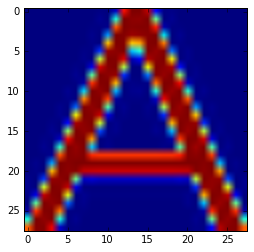

In [9]:
display_random_pickled_image('A')

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [10]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [12]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [13]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441


## Intro to tensorflow

tensorflow usually consists of two parts:
- building a graph, where the connection between nodes are specified
- running a session, where the graph will actually be evaluated

Check out https://www.tensorflow.org/get_started/get_started for a more detailed explanation.

** Declare constants **

In [14]:
# building the graph
graph = tf.Graph()
with graph.as_default():
  a = tf.constant(1.0, tf.float32)
  b = tf.constant(2.4, tf.float32)
  c = a + b # not actually evaluated

In [15]:
# running a session
with tf.Session(graph=graph) as session:
 print(session.run([c]))

[3.4000001]


** Declaring variables (which can be used as trainable parameters) **

In [16]:
# building the graph
graph = tf.Graph()
with graph.as_default():
  a = tf.Variable([1.0], tf.float32) # 1.0 is the initial value
  b = tf.Variable([0.4], tf.float32)
  c = a + b # not actually evaluated

In [17]:
# running a session
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run() # (absolutely needed) variable initialization happens here
  print(session.run([c]))

[array([ 1.39999998], dtype=float32)]


** Declaring placeholder (then external data can be passed as dictionary) **

In [18]:
# building the graph
graph = tf.Graph()
with graph.as_default():
  a = tf.placeholder(tf.float32) # no initial value(s) needed
  b = tf.placeholder(tf.float32)
  c = a + b # not actually evaluated

In [19]:
# running a session
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run() # (absolutely needed) variable initialization happens here
  print(session.run([c],feed_dict={a:1.0, b:-0.2}))

[0.80000001]


** Let's try doing a linear fit (by doing GD) **

In [20]:
# building the graph
graph = tf.Graph()
with graph.as_default():
  # Model parameters
  W = tf.Variable([.3], tf.float32)
  b = tf.Variable([-.3], tf.float32)
  # Model input and output
  x = tf.placeholder(tf.float32)
  linear_model = W * x + b
  y = tf.placeholder(tf.float32)
  # loss
  loss = tf.reduce_sum(tf.square(linear_model - y)) # sum of the squares
  # optimizer (using gradient descent)
  optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)


In [21]:
# training data
x_train = [1,2,3,4]
y_train = [0,-1,-2,-3]

# running a session
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run() # (absolutely needed) variable initialization happens here
  for i in range(1000):
      session.run([optimizer, loss], feed_dict={x:x_train, y:y_train})

  # evaluate training accuracy
  curr_W, curr_b, curr_loss  = session.run([W, b, loss], feed_dict={x:x_train, y:y_train})
  print("W: %s b: %s loss: %s"%(curr_W, curr_b, curr_loss))


W: [-0.9999969] b: [ 0.99999082] loss: 5.69997e-11


## Classify notMNIST data set using a 2-layer FC neural network

First reload the data we generated

In [22]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [23]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


Define the accuracy function

In [24]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Now, we will train a 2-layer neural network. (RELU: rectified linear units) (Dropout: force the network to learn redunant representation of the data and avoid overfitting)

In [25]:
batch_size = 128
num_relus = 1024
beta = 0.001
dropout_rate = 0.77
init_learning_rate = 0.1

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  w1 = tf.Variable(tf.truncated_normal([image_size * image_size, num_relus]))
  b1 = tf.Variable(tf.zeros([num_relus]))
  
  w2 = tf.Variable(tf.truncated_normal([num_relus, num_labels]))
  b2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), dropout_rate), w2) + b2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
    + beta * tf.nn.l2_loss(w1) + beta * tf.nn.l2_loss(w2)
  
  # Optimizer.
  global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, 20000, 0.90, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w2) + b2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w2) + b2)

In [26]:
num_steps = 8001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 699.287292
Minibatch accuracy: 11.7%
Validation accuracy: 24.4%
Minibatch loss at step 500: 309.646729
Minibatch accuracy: 75.8%
Validation accuracy: 81.7%
Minibatch loss at step 1000: 266.506500
Minibatch accuracy: 82.0%
Validation accuracy: 83.5%
Minibatch loss at step 1500: 233.675049
Minibatch accuracy: 83.6%
Validation accuracy: 83.7%
Minibatch loss at step 2000: 212.289948
Minibatch accuracy: 79.7%
Validation accuracy: 84.1%
Minibatch loss at step 2500: 191.635880
Minibatch accuracy: 79.7%
Validation accuracy: 83.1%
Minibatch loss at step 3000: 174.887985
Minibatch accuracy: 81.2%
Validation accuracy: 81.5%
Minibatch loss at step 3500: 156.022095
Minibatch accuracy: 78.1%
Validation accuracy: 79.6%
Minibatch loss at step 4000: 141.558289
Minibatch accuracy: 73.4%
Validation accuracy: 82.9%
Minibatch loss at step 4500: 127.388718
Minibatch accuracy: 80.5%
Validation accuracy: 75.0%
Minibatch loss at step 5000: 113.660141
Minibatch accuracy: 79

## Classify notMNIST data set using a lazy 2-layer TT network
This is a **lazy** implementation of the tensor net, because only the weight matrix at the first layer is represented as an MPO.

The training instances, on the other hand, are still represented as long vectors, other than as MPSs. Therefore, when doing the matrix-vector multiplication, the MPO has to be converted back into a full weight matrix. This way I can make minimal change of the previous code. (I am lazy ...)

This implementation illustrates that, with far less independent parameters (as those in the MPO), the accuracy of the TT network is actually comparable to a fully connected 2-layer neural network.

The first layer, when fully connected, has a weight matrix of size (28x28, 1024). Our goal below is to convert this weight matrix into an TT representaion (or, **MPO -- matrix product operator**).

Notice that 28x28 = 2x2x7x7x2x2, and 1024 = 2x4x4x4x4x2. So this can be visualized as an MPO with outgoing indices of sizes (2, 4, 4, 4, 4, 2) and ingoing indices of sizes (2, 2, 7, 7, 2, 2).

This means, W(i0 i1 i2 i3 i4 i5, j0 j1 j2 j3 j4 j5) = G0[i0,j0] x G1[i1,j1] x G2[i2,j2] x G3[i3,j3] x G4[i4,j4] x G5[i5,j5], where the i's and j's are the of sizes (2, 4, 4, 4, 4, 2) and (2, 2, 7, 7, 2, 2).

The TT rank r (or **max bond dimension**) controls the number of paramters in the core tensors G1, ..., G6.

In [27]:
TT_rank = 3
TT_out_sizes = [2,2,7,7,2,2]
TT_in_sizes = [2,4,4,4,4,2]

In [28]:
batch_size = 128
num_relus = 1024 # don't change this without changing TT_o_sizes
beta = 0.001
dropout_rate = 0.77
init_learning_rate = 0.1

graph = tf.Graph()
with graph.as_default():
    
  nm = tf.constant(1024.0);
    
  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)    
  
  # Variables.
  # TT core tensors G0, .., G5, hard coded. 
  # Sorry for the visual noise
  G = []
  G.append(tf.Variable(tf.truncated_normal([TT_out_sizes[0], TT_in_sizes[0], TT_rank])))
  G.append(tf.Variable(tf.truncated_normal([TT_out_sizes[1], TT_in_sizes[1], TT_rank, TT_rank])))
  G.append(tf.Variable(tf.truncated_normal([TT_out_sizes[2], TT_in_sizes[2], TT_rank, TT_rank])))
  G.append(tf.Variable(tf.truncated_normal([TT_out_sizes[3], TT_in_sizes[3], TT_rank, TT_rank])))
  G.append(tf.Variable(tf.truncated_normal([TT_out_sizes[4], TT_in_sizes[4], TT_rank, TT_rank])))
  G.append(tf.Variable(tf.truncated_normal([TT_out_sizes[5], TT_in_sizes[5], TT_rank])))

  out_size = TT_out_sizes[0]
  in_size = TT_in_sizes[0]

  # w1 = G[0] * G[1]
  w1 = tf.tensordot(G[0], G[1], [[2],[2]])
  w1 = tf.transpose(w1, perm=[0,2,1,3,4])
  out_size *= TT_out_sizes[1]
  in_size *= TT_in_sizes[1]
  w1 = tf.reshape(w1, [out_size, in_size, -1])/nm # -1 means this size will be inferred

  # w1 = w1 * G[i]
  for i in range(2,5):
    w1 = tf.tensordot(w1, G[i], [[2],[2]])
    w1 = tf.transpose(w1, perm=[0,2,1,3,4])
    out_size *= TT_out_sizes[i]
    in_size *= TT_in_sizes[i]
    w1 = tf.reshape(w1, [out_size, in_size, -1]) # -1 means this size will be inferred
    
  # w1 = w1 * G[5]
  w1 = tf.tensordot(w1, G[5], [[2],[2]])
  w1 = tf.transpose(w1, perm=[0,2,1,3])
  out_size *= TT_out_sizes[5]
  in_size *= TT_in_sizes[5]
  w1 = tf.reshape(w1, [out_size, in_size]) # -1 means this size will be inferred
    
  b1 = tf.Variable(tf.zeros([num_relus]))
  
  w2 = tf.Variable(tf.truncated_normal([num_relus, num_labels]))
  b2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, w1) + b1), dropout_rate), w2) + b2
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) \
    + beta * tf.nn.l2_loss(w1) + beta * tf.nn.l2_loss(w2)
  
  # Optimizer.
  global_step = tf.Variable(0, trainable=False)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(init_learning_rate, global_step, 20000, 0.90, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss,global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, w1) + b1), w2) + b2)
  test_prediction = tf.nn.softmax(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, w1) + b1), w2) + b2)

In [29]:
num_steps = 8001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 8.330903
Minibatch accuracy: 8.6%
Validation accuracy: 11.4%
Minibatch loss at step 500: 4.690030
Minibatch accuracy: 69.5%
Validation accuracy: 78.2%
Minibatch loss at step 1000: 4.043419
Minibatch accuracy: 78.9%
Validation accuracy: 79.8%
Minibatch loss at step 1500: 3.557302
Minibatch accuracy: 83.6%
Validation accuracy: 81.1%
Minibatch loss at step 2000: 3.388589
Minibatch accuracy: 80.5%
Validation accuracy: 81.5%
Minibatch loss at step 2500: 3.249811
Minibatch accuracy: 73.4%
Validation accuracy: 82.1%
Minibatch loss at step 3000: 2.935875
Minibatch accuracy: 78.9%
Validation accuracy: 82.4%
Minibatch loss at step 3500: 2.754652
Minibatch accuracy: 77.3%
Validation accuracy: 82.4%
Minibatch loss at step 4000: 2.520379
Minibatch accuracy: 80.5%
Validation accuracy: 82.8%
Minibatch loss at step 4500: 2.213370
Minibatch accuracy: 82.8%
Validation accuracy: 83.0%
Minibatch loss at step 5000: 2.119478
Minibatch accuracy: 79.7%
Validation accuracy

## Compare the two methods (by looking at the number of free parameters)
**The implication is that a FC neural network's weight matrix is highly redundant...**

In [30]:
FC_num_params = image_size * image_size * num_relus
FC_num_params

802816

In [31]:
TT_i_sizes = TT_in_sizes
TT_o_sizes = TT_out_sizes
TT_num_params = TT_i_sizes[0]*TT_o_sizes[0]*TT_rank + TT_i_sizes[5]*TT_o_sizes[5]*TT_rank
for i in range(1,5):
  TT_num_params += TT_i_sizes[i]*TT_o_sizes[i]*TT_rank*TT_rank
TT_num_params

672

In [32]:
compression_rate = 100*(1.0 - float(TT_num_params)/FC_num_params)
print("Compression rate = %.3f%%" % compression_rate)

Compression rate = 99.916%
